# Aula 02: Redes Neurais Recorrentes
* Exemplo de uma LSTM
* Testando a normalização pela média e desvio-padrão



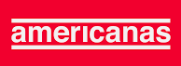

## Objetivos:
* Previsão do valor de uma ação: caso Americas AMER3.SA;
* Fonte de dados: Yahoo Finance: https://tinyurl.com/mphcy6c6;
* Entender o processo de extração de dados e pré-processamento de uma RNN;
* Entender as métricas que podem ser utilizadas para esse problema;
* Testar diferentes formas de normalização de dados;

## Importação e instalação das bibliotecas

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import math

# utilizada para obter os dados das ações
import yfinance as yf

from sklearn.metrics import (mean_squared_error, 
  mean_absolute_error, 
  mean_absolute_percentage_error, 
  roc_curve, confusion_matrix, 
  accuracy_score, 
  f1_score) # métricas

from sklearn.preprocessing import MinMaxScaler  # usado na etapa de normalização de dados

In [119]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [120]:
# bibliotecas para rodar o modelo RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, Precision, Recall

In [121]:
# Definição de cores para gráficos
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Análise e pré-processamendo dos dados

### Carregamento de dados

In [122]:
# baixando os valores das ações da Americanas

ticker = 'AMER3.SA'
start_date = '2005-03-30'
end_date = '2023-03-30'

df_data_download = yf.download(ticker, start=start_date, end=end_date)

df_data_download.head(-5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-03-30,20.400707,20.400707,18.899357,19.093649,18.397427,6428031
2005-03-31,19.243784,19.243784,17.309690,19.093649,18.397427,4726164
2005-04-01,19.093649,19.429245,18.457783,18.546097,17.869843,805075
2005-04-04,18.104523,18.192839,16.832790,17.450994,16.814672,338448
2005-04-05,17.662951,17.662951,17.000589,17.194881,16.567898,419748
...,...,...,...,...,...,...
2023-03-15,1.020000,1.050000,1.000000,1.030000,1.030000,29432000
2023-03-16,1.040000,1.100000,1.040000,1.050000,1.050000,39141700
2023-03-17,1.050000,1.070000,1.030000,1.040000,1.040000,25232500


In [123]:
# criando uma cópia dos dados originais
# stock_mv: Stock Market Value
df_stock_mv = df_data_download.copy()
df_stock_mv.shape

(4476, 6)

In [124]:
df_stock_mv.head(-5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-03-30,20.400707,20.400707,18.899357,19.093649,18.397427,6428031
2005-03-31,19.243784,19.243784,17.309690,19.093649,18.397427,4726164
2005-04-01,19.093649,19.429245,18.457783,18.546097,17.869843,805075
2005-04-04,18.104523,18.192839,16.832790,17.450994,16.814672,338448
2005-04-05,17.662951,17.662951,17.000589,17.194881,16.567898,419748
...,...,...,...,...,...,...
2023-03-15,1.020000,1.050000,1.000000,1.030000,1.030000,29432000
2023-03-16,1.040000,1.100000,1.040000,1.050000,1.050000,39141700
2023-03-17,1.050000,1.070000,1.030000,1.040000,1.040000,25232500


### Tratamento do dataset



In [125]:
# verificando e visualizando se há informações vazias ou em branco
# isna(): False se está preenchido e True para não preenchido
# any(axis = 1): se em alguma linha o resultado for True, retorna a linha com info faltantes (NaN por exemplo)

df_stock_mv[df_stock_mv.isna().any(axis = 1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [126]:
# index nessa importação é a data dos registros

df_stock_mv.columns
print(df_stock_mv.index)

DatetimeIndex(['2005-03-30', '2005-03-31', '2005-04-01', '2005-04-04',
               '2005-04-05', '2005-04-06', '2005-04-07', '2005-04-08',
               '2005-04-11', '2005-04-12',
               ...
               '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20',
               '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
               '2023-03-27', '2023-03-28'],
              dtype='datetime64[ns]', name='Date', length=4476, freq=None)


In [127]:
# descarta alguma linha que possui em algum valor faltante
df_stock_mv = df_stock_mv.dropna()

In [128]:
len(df_stock_mv)

4476

In [129]:
# faremos a previsão utilizando apenas o valor de fechamento da ação!
# modelo para fins didáticos, não deverá ser usado para análise de compra/venda de ativos
closed_value_stock = df_stock_mv
print(closed_value_stock)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2005-03-30  20.400707  20.400707  18.899357  19.093649  18.397427   6428031
2005-03-31  19.243784  19.243784  17.309690  19.093649  18.397427   4726164
2005-04-01  19.093649  19.429245  18.457783  18.546097  17.869843    805075
2005-04-04  18.104523  18.192839  16.832790  17.450994  16.814672    338448
2005-04-05  17.662951  17.662951  17.000589  17.194881  16.567898    419748
...               ...        ...        ...        ...        ...       ...
2023-03-22   1.140000   1.150000   1.060000   1.060000   1.060000  75864300
2023-03-23   1.070000   1.080000   1.010000   1.020000   1.020000  74923300
2023-03-24   1.030000   1.040000   0.990000   1.020000   1.020000  46412700
2023-03-27   1.030000   1.040000   1.000000   1.010000   1.010000  22257300
2023-03-28   1.000000   1.020000   0.980000   1.010000   1.010000  32166500

[4476 rows 

### Visualizando os dados de entrada

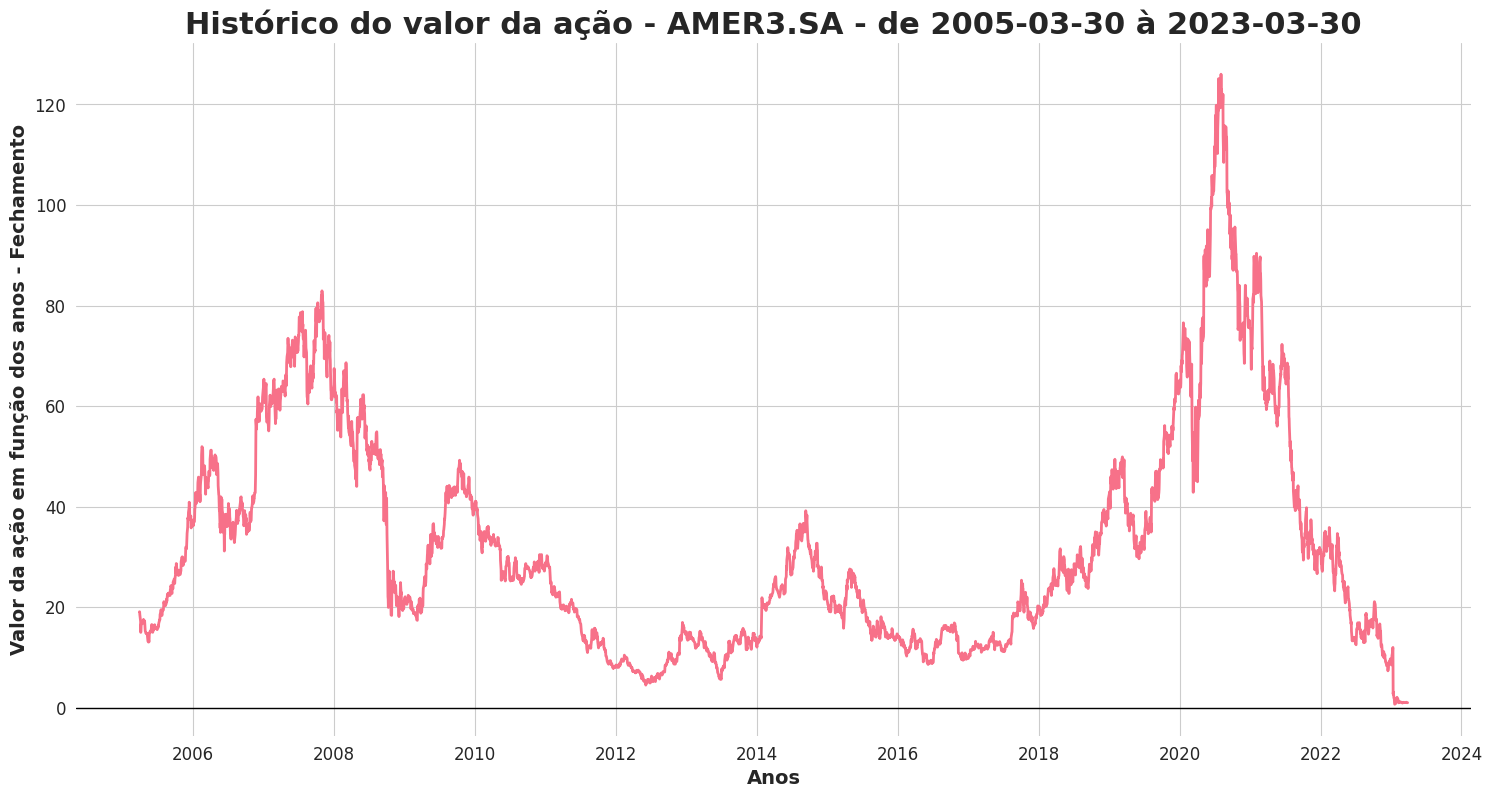

In [130]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote o gráfico
ax.plot(df_stock_mv['Close'], linewidth=2)

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Anos', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor da ação em função dos anos - Fechamento', fontsize=14, fontweight='bold')
ax.set_title(f'Histórico do valor da ação - {ticker} - de {start_date} à {end_date}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Adicione uma linha horizontal em y=0 para melhorar a visualização
ax.axhline(y=0, color='black', linewidth=1)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()


### Preparando os dados de Teste e de Treino

In [131]:
# define o intervalo anterior para a estimativa
# pode ser qualquer valor.
# o algoritmo é mais sensível para previsão com os últimos dados

days_time_step = 15

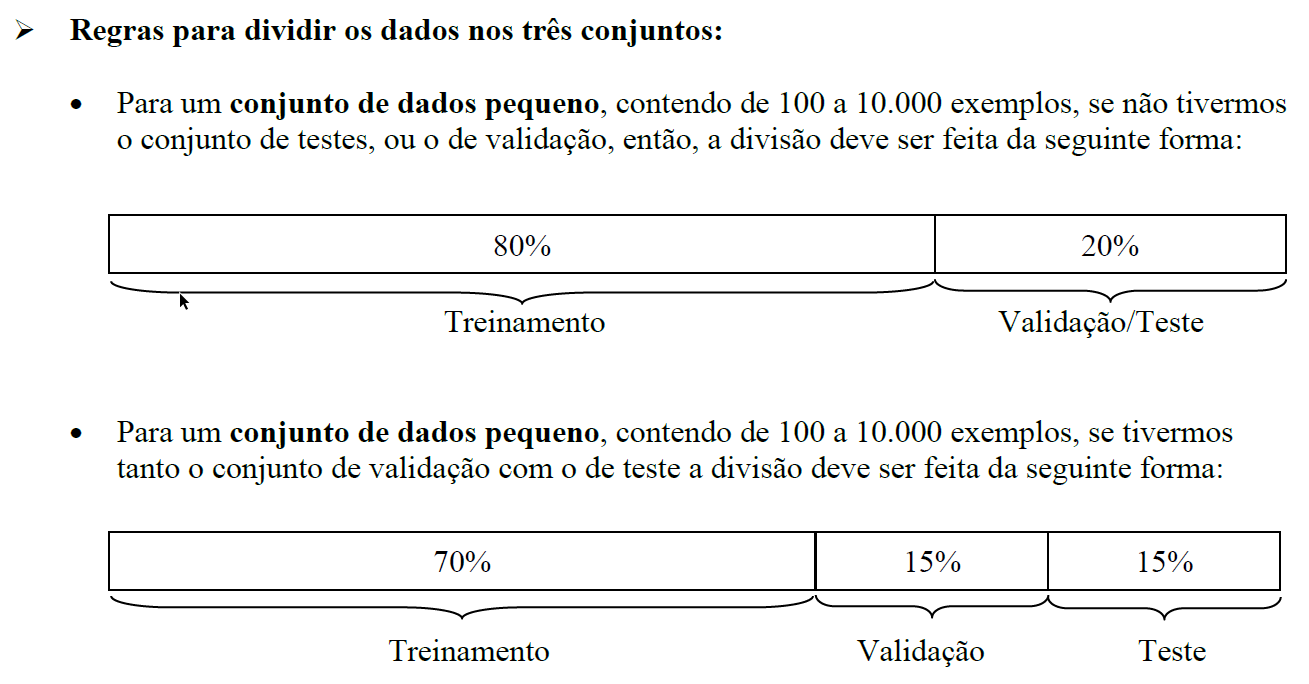

### Divisão do conjunto de dados

In [132]:
# de acordo com a tabela acima, faremos a divisão 80%/20%:
training_size = int(len(closed_value_stock) * 0.80)

# em uma RNN LSTM, a ordem dos elementos é essencial para a relação de recorrência
# train_data e test_data não estão normalizados
train_data = closed_value_stock[:training_size]
test_data = closed_value_stock[training_size:]

train_data.shape, test_data.shape

((3580, 6), (896, 6))

### Visualizando os dados de teste antes da normalização
* apenas uma verificação secundária


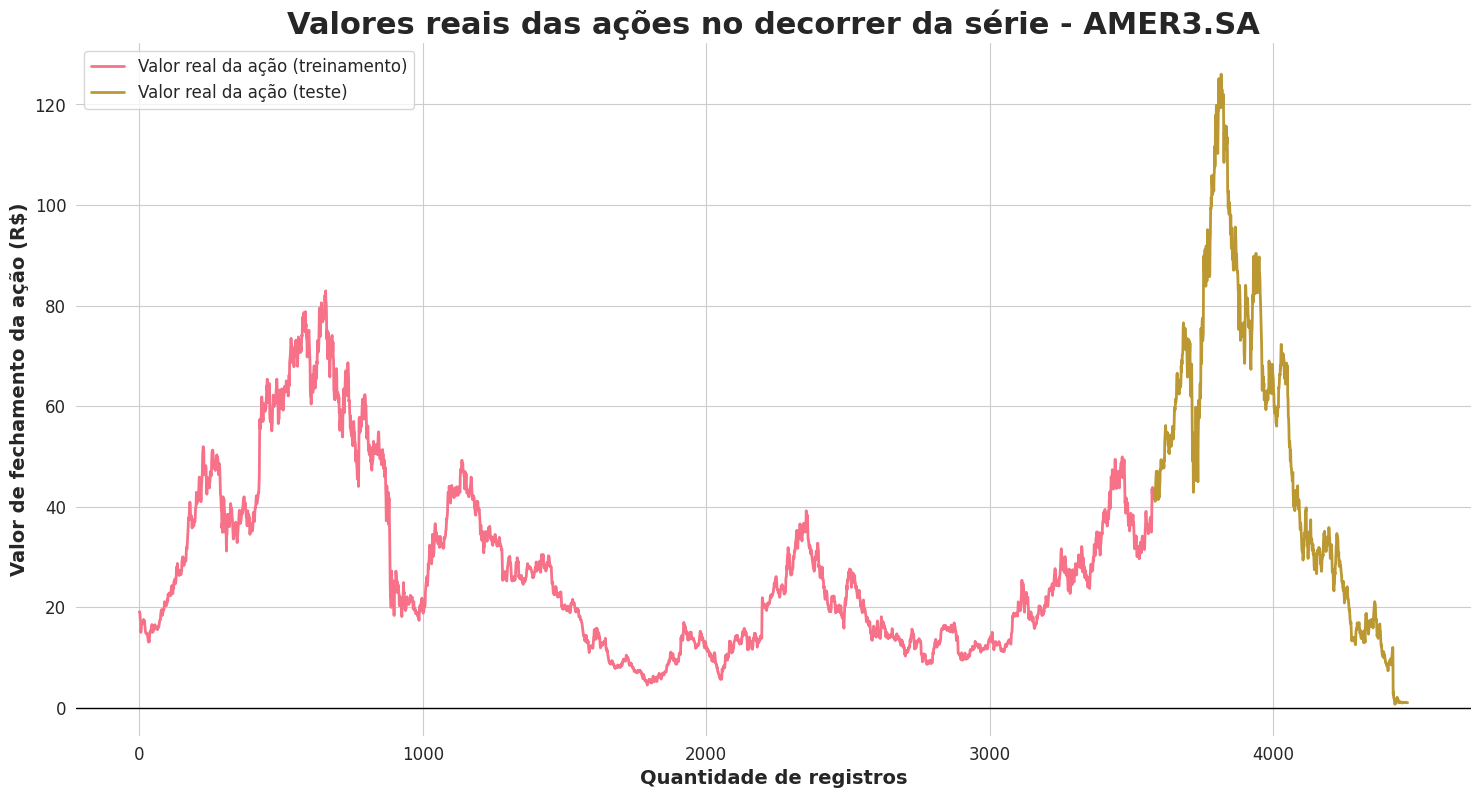

In [133]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Define os índices para os dados de treinamento e teste
train_index = range(0, len(train_data['Close']))
test_index = range(len(train_data['Close']), len(train_data['Close']) + len(test_data['Close']))

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote os dados de treinamento e teste
ax.plot(train_index, train_data['Close'], label='Valor real da ação (treinamento)', linewidth=2)
ax.plot(test_index, test_data['Close'], label='Valor real da ação (teste)', linewidth=2)

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Quantidade de registros', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor de fechamento da ação (R$)', fontsize=14, fontweight='bold')
ax.set_title(f'Valores reais das ações no decorrer da série - {ticker}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Adicione uma linha horizontal em y=0 para melhorar a visualização
ax.axhline(y=0, color='black', linewidth=1)

# Adicione legendas
ax.legend(fontsize=12)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()

### Normalização dos dados
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [134]:
from sklearn.preprocessing import StandardScaler

# criando o objeto StandardScaler
scaler = StandardScaler()

# Ajuste e transforme os dados de entrada usando média e desvio-padrão
closed_value_stock['Close'] = scaler.fit_transform(np.array(closed_value_stock['Close']).reshape(-1, 1))

closed_value_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-03-30,20.400707,20.400707,18.899357,-0.585068,18.397427,6428031
2005-03-31,19.243784,19.243784,17.309690,-0.585068,18.397427,4726164
2005-04-01,19.093649,19.429245,18.457783,-0.609407,17.869843,805075
2005-04-04,18.104523,18.192839,16.832790,-0.658084,16.814672,338448
2005-04-05,17.662951,17.662951,17.000589,-0.669468,16.567898,419748
...,...,...,...,...,...,...
2023-03-22,1.140000,1.150000,1.060000,-1.386660,1.060000,75864300
2023-03-23,1.070000,1.080000,1.010000,-1.388438,1.020000,74923300
2023-03-24,1.030000,1.040000,0.990000,-1.388438,1.020000,46412700


### Normalização dos conjuntos de treino e teste

In [135]:
# em uma RNN LSTM, a ordem dos elementos é essencial para a relação de recorrência 
train_data = closed_value_stock[:training_size]
test_data = closed_value_stock[training_size:]

train_data.shape, test_data.shape

((3580, 6), (896, 6))

### Visualizando os dados de teste normalizados

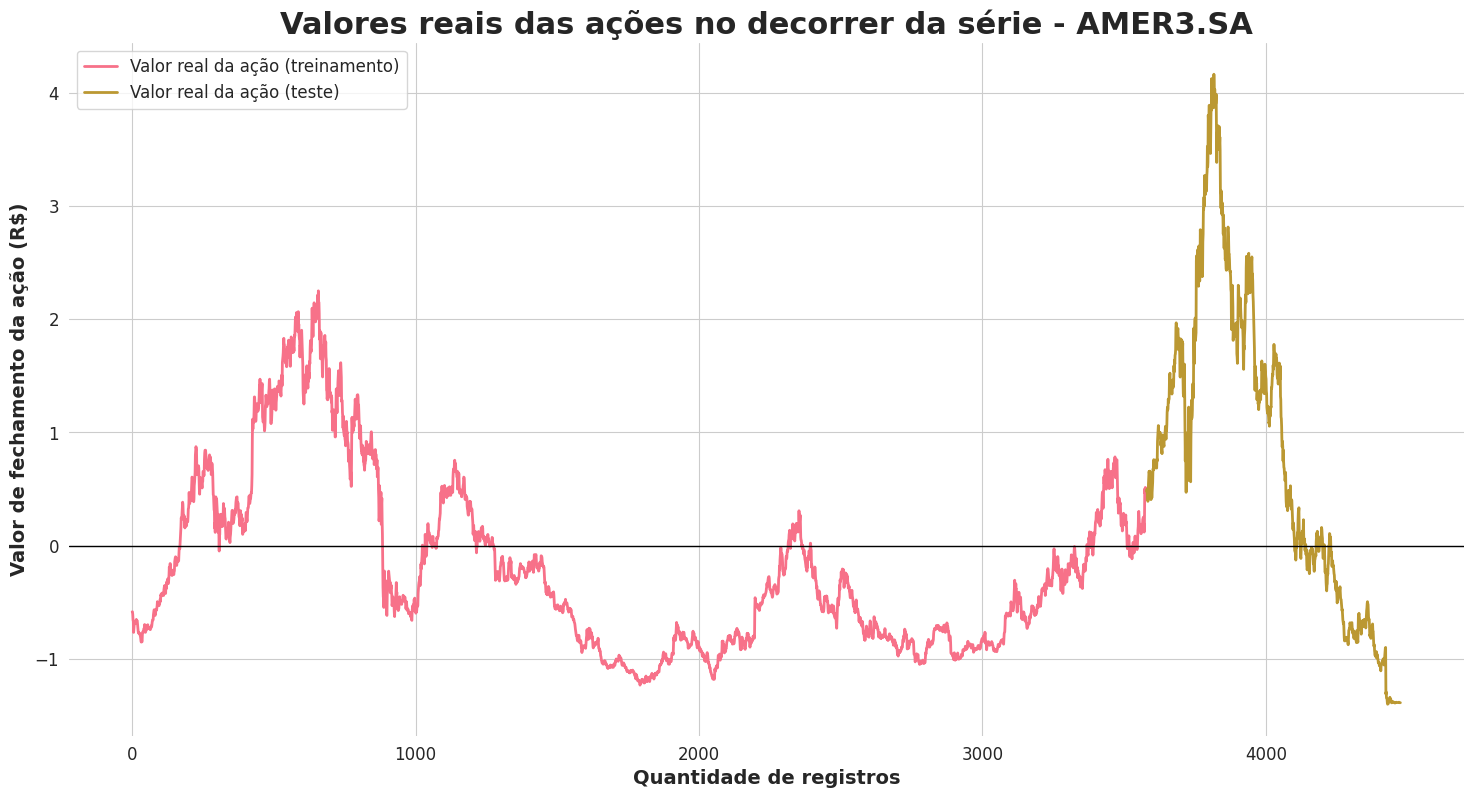

In [136]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Define os índices para os dados de treinamento e teste
train_index = range(0, len(train_data['Close']))
test_index = range(len(train_data['Close']), 
                   len(train_data['Close']) + len(test_data['Close']))

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote os dados de treinamento e teste
ax.plot(train_index, train_data['Close'], 
        label='Valor real da ação (treinamento)', linewidth=2)
ax.plot(test_index, test_data['Close'], 
        label='Valor real da ação (teste)', linewidth=2)

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Quantidade de registros', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor de fechamento da ação (R$)', fontsize=14, 
              fontweight='bold')
ax.set_title(f'Valores reais das ações no decorrer da série - {ticker}', 
             fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Adicione uma linha horizontal em y=0 para melhorar a visualização
ax.axhline(y=0, color='black', linewidth=1)

# Adicione legendas
ax.legend(fontsize=12)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()

### Pré-processamento

#### Sequências de treino e teste

In [137]:
# função para a criação das sequências de treinamento e teste
def create_sequences_LSTM(X, y, days_time_step):
    Xs, ys = [], []
    for i in range(len(X) - days_time_step):
        Xs.append(X.iloc[i: (i + days_time_step)].values)
        ys.append(y.iloc[i + days_time_step])
    return np.array(X), np.array(y)

Obs.: etapas da função:

* Inicializa duas listas vazias,`Xs` e `ys`, que armazenarão as sequências de entrada e saída, respectivamente.
* Executa um loop for, que começa em `0` e vai até o tamanho de `X` menos o valor de `days_time_step`. A variável i será usada como índice no loop.
* Dentro do loop, extrai uma subsequência do `DataFrame X`, começando no índice `i` e indo até `(i + days_time_step)`. Converte essa subsequência em um array NumPy usando o método `.values` e o adiciona à lista Xs.
* Extrai o valor de y no índice `(i + days_time_step)` e o adiciona à lista `ys`.
* Após o término do loop, converte as listas `Xs` e `ys` em arrays NumPy usando `np.array` e retorna ambos.

Exemplos:

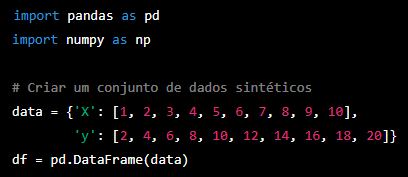

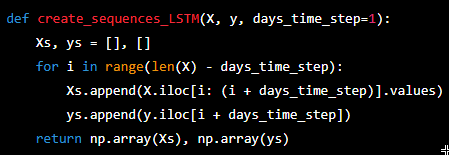

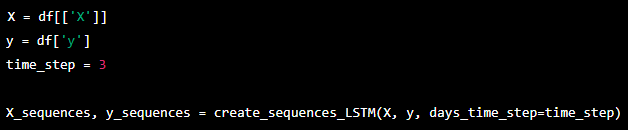

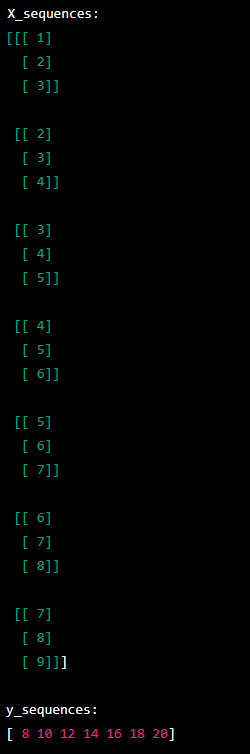

In [138]:
# criando as sequências de treino e teste - formato NumPy
X_train, y_train = create_sequences_LSTM(train_data[['Close']], train_data['Close'], days_time_step)
X_test, y_test = create_sequences_LSTM(test_data[['Close']], test_data['Close'], days_time_step)

In [139]:
# reformatar os dados para o formato necessário pela RNN
# formado: (batch_size, timesteps, input_features)

#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Modelo RNN LSTM e definição de métricas

In [140]:
# adiciona o MSPE no cálculo das métricas usando TF
# MSPE não é uma métrica padrão no TF

class MeanSquaredPercentageError(tf.keras.metrics.Metric):
    def __init__(self, name='mspe', **kwargs):
        super().__init__(name=name, **kwargs)
        self.sum_squared_percentage_error = self.add_weight(name='sum_squared_percentage_error', 
                        initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        squared_percentage_error = tf.math.squared_difference(y_true, y_pred) / tf.maximum(tf.abs(y_true), 1e-7)
        self.sum_squared_percentage_error.assign_add(tf.reduce_sum(squared_percentage_error))
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))

    def result(self):
        return self.sum_squared_percentage_error / self.count

    def reset_states(self):
        self.sum_squared_percentage_error.assign(0.0)
        self.count.assign(0.0)


In [170]:
####################
UNITS_1 = 128
UNITS_2 = 64
####################

# Define callback para parada 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Escolher as métricas apropriadas para seu problema
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
    MeanSquaredPercentageError(name='mspe')
]

def make_model(METRICS, INPUT_DIM):
    # Configuração da rede
    lstm = tf.keras.Sequential([
        tf.keras.layers.LSTM(UNITS_1, return_sequences=True, 
        input_shape=(days_time_step, 1)), tf.keras.layers.LSTM(UNITS_2), 
        tf.keras.layers.Dense(1)
    ])

    lstm.compile(loss=tf.losses.MeanSquaredError(), 
                 optimizer=tf.optimizers.Adam(), metrics=METRICS)

    return lstm

Lista de Optimizers:

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [172]:
# Determina número de carateríticas
features_shape = X_train.shape[1]
print('Dimensão dos dados de entrada =', features_shape)

# Cria LSTM já compilada
lstm = make_model(METRICS, features_shape)
lstm.summary()

Dimensão dos dados de entrada = 1
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 15, 128)           66560     
                                                                 
 lstm_15 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


### Treinando o modelo

In [173]:
##################
EPOCHS = 30
BATCH_SIZE = 32
##################

# treinando o modelo
history = lstm.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/30
 96/101 [===========================>..] - ETA: 0s - loss: 0.4014 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 3072.0000 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - mse: 0.4014 - mae: 0.4712 - rmse: 0.6335 - mspe: 0.4283

/usr/local/lib/python3.9/dist-packages/keras/engine/training.py:2448: UserWarning: Metric MeanSquaredPercentageError implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


101/101 [==============================] - 8s 23ms/step - loss: 0.3833 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 3222.0000 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - mse: 0.3833 - mae: 0.4544 - rmse: 0.6191 - mspe: 0.4096 - val_loss: 0.0537 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 358.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_mse: 0.0537 - val_mae: 0.2236 - val_rmse: 0.2318 - val_mspe: 1.0744
Epoch 2/30
101/101 [==============================] - 1s 12ms/step - loss: 0.0253 - tp: 547.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 2675.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.1698 - auc: 0.0000e+00 - mse: 0.0253 - mae: 0.0921 - rmse: 0.1590 - mspe: 0.0442 - val_loss: 0.0105 - val_tp: 70.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 288.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_rec

In [174]:
# resumo dos resultados do modelo
results = lstm.evaluate(X_test, y_test)
print(dict(zip(lstm.metrics_names, results)))

28/28 [==============================] - 0s 4ms/step - loss: 0.5111 - tp: 419.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 477.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.4676 - auc: 0.0000e+00 - mse: 0.5111 - mae: 0.5147 - rmse: 0.7149 - mspe: 0.4204
{'loss': 0.5110557675361633, 'tp': 419.0, 'fp': 0.0, 'tn': 0.0, 'fn': 477.0, 'accuracy': 0.0, 'precision': 1.0, 'recall': 0.4676339328289032, 'auc': 0.0, 'mse': 0.5110557675361633, 'mae': 0.5146546959877014, 'rmse': 0.7148816585540771, 'mspe': 0.4204464852809906}


### Observações sobre as métricas:

Nem todas métricas são importantes para as RNN. Vejamos algumas definições:

- **Falsos negativos** e **falsos positivos** são exemplos classificados **incorretamente**.


* **Verdadeiros negativos** e **verdadeiros positivos** são exemplos classificados **corretamente**.


* **Exatidão ("accuracy")** é a porcentagem de exemplos classificados corretamente:


 $$\frac{\text{exemplos classificados corretamente}}{\text{total de exemplos}}$$
 
 
* **Precisão ("precision")** é a porcentagem de exemplos positivos classificados corretamente:

$$\frac{\text{verdadeiros positivos}}{\text{verdadeiros positivos + falsos positivos}}$$


* **Revocação ("recall")** é a porcentagem de exemplos positivos reais que foram classificados corretamente:


$$\frac{\text{verdadeiros positivos}}{\text{verdadeiros positivos + falsos negativos}}$$


* **AUC** refere-se à área sob uma curva de característica de operação do receptor (ROC-AUC). Essa métrica é igual à probabilidade de que um classificador classifique uma amostra  positiva mais alta do que uma amostra negativa [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)


**Observação**: A métrica RMSE pode ser usada para avaliar a precisão do modelo em prever valores contínuos, como previsões de séries temporais. Enquanto a métrica MSPE pode ser útil para avaliar o desempenho do modelo em prever valores percentuais.

Portanto, é importante escolher as métricas que são mais apropriadas para a tarefa específica e os dados com os quais você está trabalhando. Por exemplo, se você estiver trabalhando com séries temporais com uma grande variação entre valores, o RMSE pode não ser a métrica mais apropriada e pode ser mais adequado usar uma métrica como o MAE (Mean Absolute Error).

## Realizando as previsões

In [175]:
# previsões
y_train_pred = lstm.predict(X_train)
y_test_pred = lstm.predict(X_test)

28/28 [==============================] - 0s 4ms/step


In [176]:
# Fazer previsões para os dados de treinamento e teste
y_train_pred = lstm.predict(X_train)
y_test_pred = lstm.predict(X_test)

# Reverter a normalização para os valores de treinamento e teste
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train_pred_orig = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred_orig = scaler.inverse_transform(y_test_pred.reshape(-1, 1))

# Calcular o RMSE para os dados de treinamento e teste
train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

# Imprimir os valores de RMSE
print('RMSE (treinamento):', train_rmse)
print('RMSE (teste):', test_rmse)

28/28 [==============================] - 0s 3ms/step
RMSE (treinamento): 5.790069508605931
RMSE (teste): 16.082908459737634


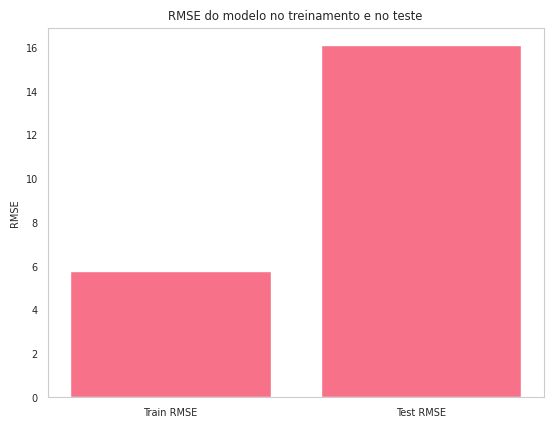

In [177]:
# Crie uma lista com os valores de RMSE e os rótulos correspondentes
rmse_values = [train_rmse, test_rmse]
labels = ['Train RMSE', 'Test RMSE']

# Crie um gráfico de barras para visualizar os valores de RMSE
plt.bar(labels, rmse_values)
plt.ylabel('RMSE')
plt.title('RMSE do modelo no treinamento e no teste')
plt.grid()
plt.show()

## Visualizando os resultados

### Conjunto de Treino vs. Teste

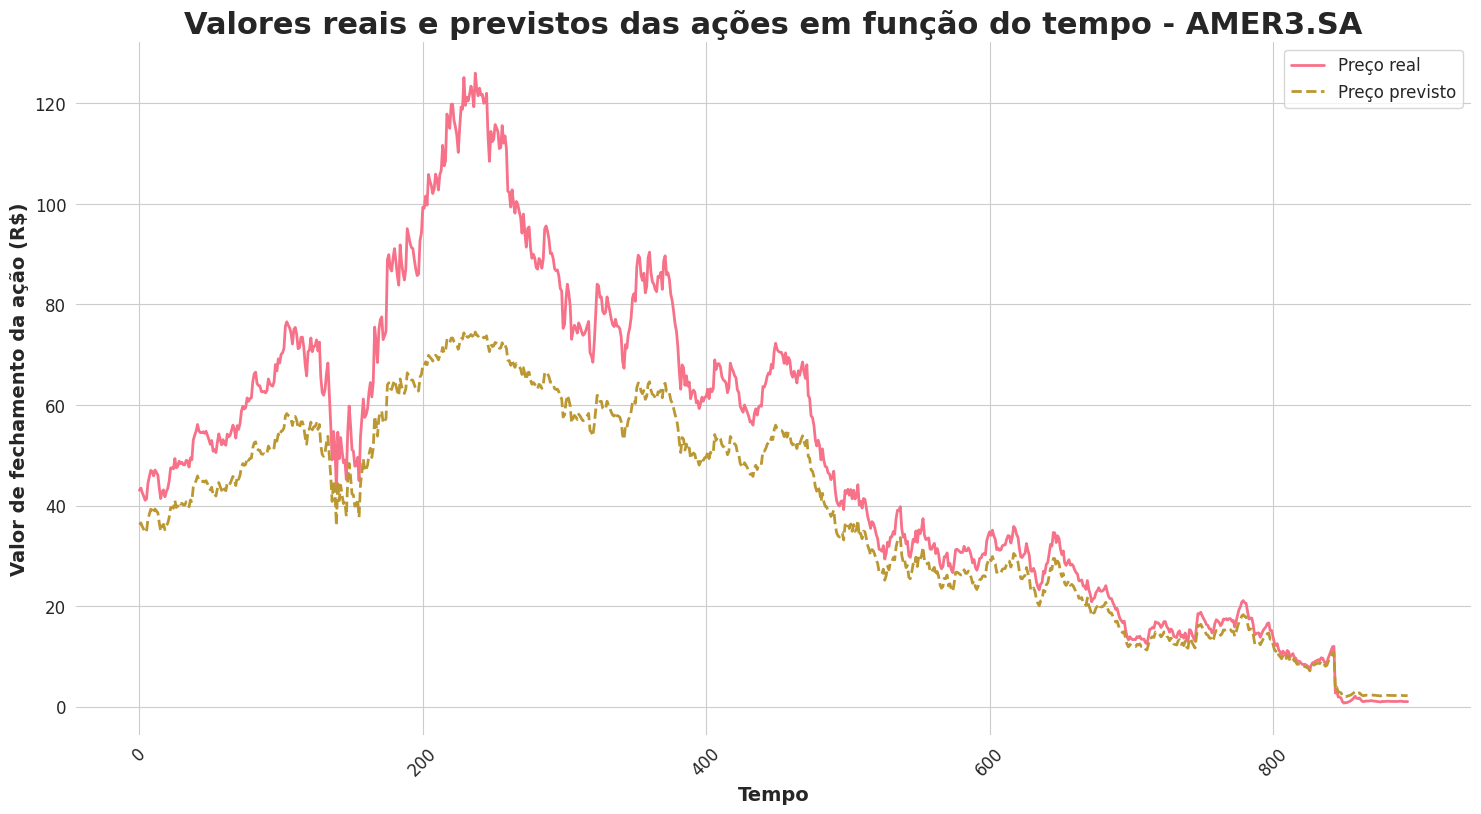

In [178]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote o preço real e previsto ao longo do tempo
ax.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Preço real', linewidth=2)
ax.plot(scaler.inverse_transform(y_test_pred.reshape(-1, 1)), label='Preço previsto', linewidth=2, linestyle='dashed')

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Tempo', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor de fechamento da ação (R$)', fontsize=14, fontweight='bold')
ax.set_title(f'Valores reais e previstos das ações em função do tempo - {ticker}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Incline os rótulos do eixo x em 45 graus
plt.xticks(rotation=45)

# Adicione legendas
ax.legend(fontsize=12)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()



## Métricas

In [149]:
# Métricas do TF
results = lstm.evaluate(X_test, y_test)
print(dict(zip(lstm.metrics_names, results)))

28/28 [==============================] - 0s 3ms/step - loss: 0.0707 - tp: 493.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 403.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.5502 - auc: 0.0000e+00 - mse: 0.0707 - mae: 0.1276 - rmse: 0.2659 - mspe: 0.0222
{'loss': 0.07069842517375946, 'tp': 493.0, 'fp': 0.0, 'tn': 0.0, 'fn': 403.0, 'accuracy': 0.0, 'precision': 1.0, 'recall': 0.5502232313156128, 'auc': 0.0, 'mse': 0.07069842517375946, 'mae': 0.1275542825460434, 'rmse': 0.26589176058769226, 'mspe': 0.022158052772283554}


/usr/local/lib/python3.9/dist-packages/keras/engine/training.py:2448: UserWarning: Metric MeanSquaredPercentageError implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


### MSE

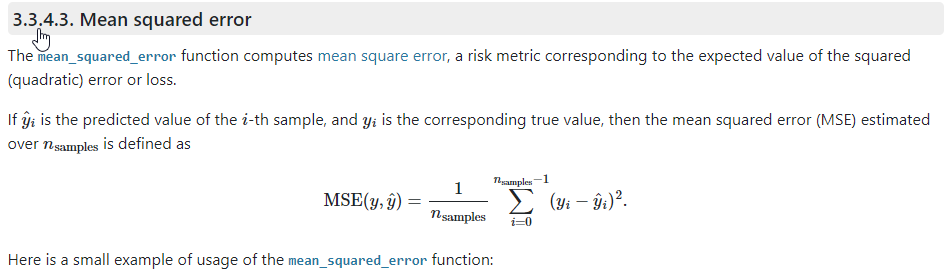

### MAE

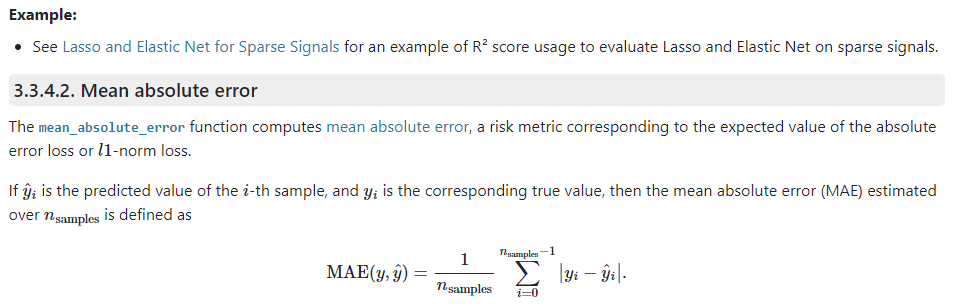

### MAPE

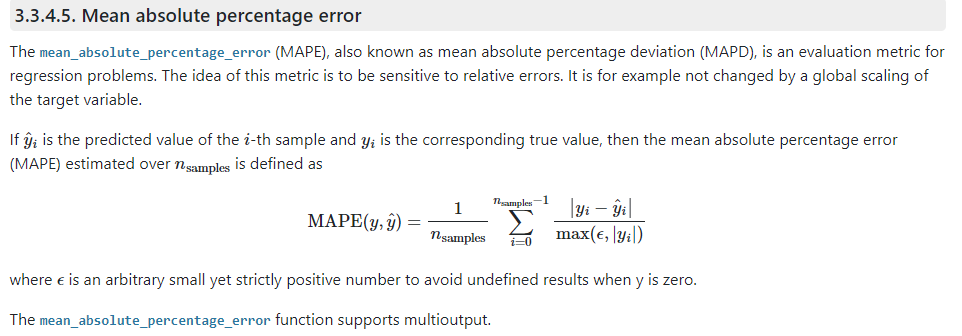

### RMSE

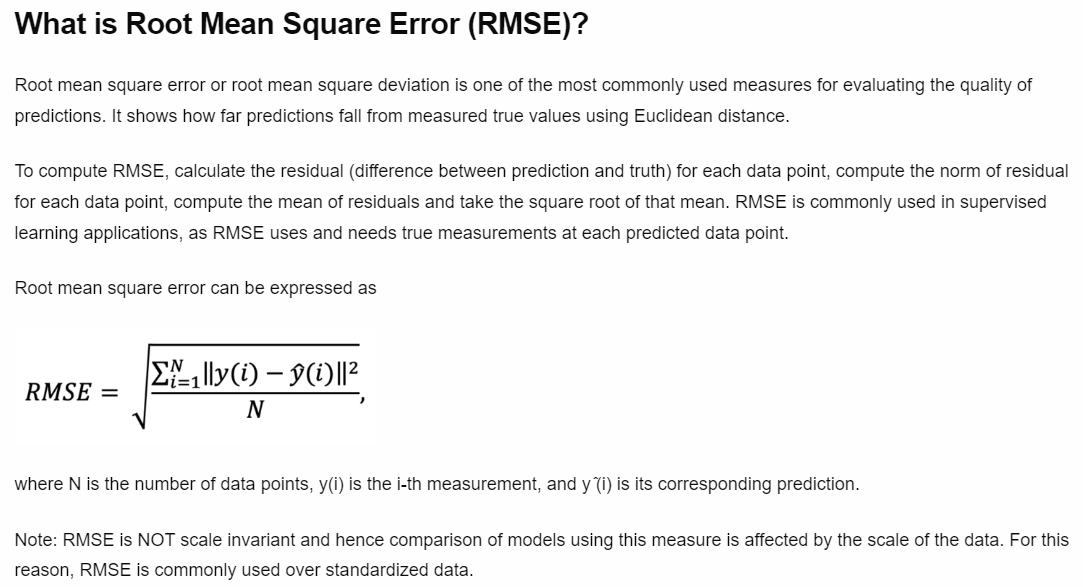

### Análises gráficas

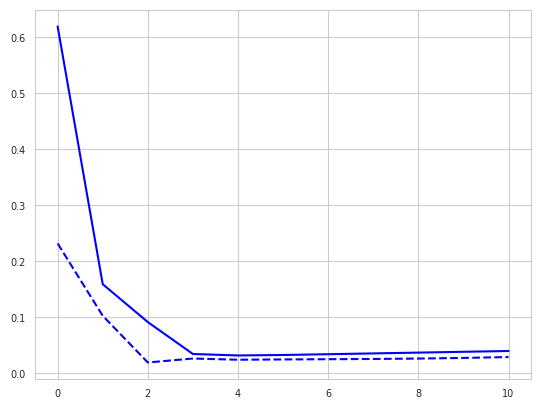

In [179]:
plt.plot(history.history['rmse'], label='Training RMSE', color='blue')
plt.plot(history.history['val_rmse'], label='Validation RMSE', color='blue', linestyle='--')

In [180]:
plt.rcParams.update({'font.size': 7})

def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'tp', 'tn']
    plt.figure(figsize=(9,6))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

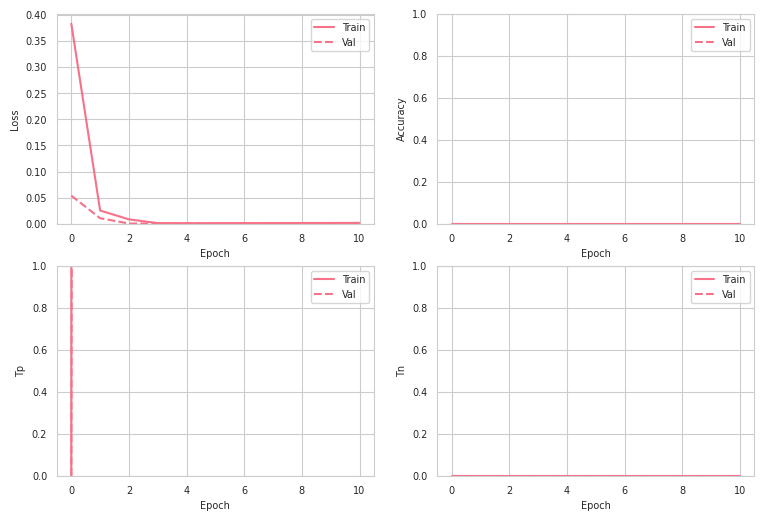

In [181]:
plot_metrics(history)

In [153]:
# conteúdo do history

history.history

{'loss': [0.4869787096977234,
  0.11061176657676697,
  0.003526256885379553,
  0.0020611933432519436,
  0.0019981814548373222,
  0.001995770027860999,
  0.002003217115998268,
  0.0020148030016571283,
  0.0020221187733113766,
  0.0020268058869987726],
 'tp': [0.0, 313.0, 625.0, 599.0, 596.0, 588.0, 587.0, 585.0, 583.0, 584.0],
 'fp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tn': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'fn': [3222.0,
  2909.0,
  2597.0,
  2623.0,
  2626.0,
  2634.0,
  2635.0,
  2637.0,
  2639.0,
  2638.0],
 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'precision': [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'recall': [0.0,
  0.09714463353157043,
  0.19397889077663422,
  0.18590937554836273,
  0.18497827649116516,
  0.1824953407049179,
  0.18218497931957245,
  0.18156424164772034,
  0.18094351887702942,
  0.18125388026237488],
 'auc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'mse': [0.4869787096977234,
  0

## Análises dos resultados

In [154]:
# nem todas as métricas serão aplicadas a esse estudo!

results = lstm.evaluate(X_test, y_test)
for name, value in zip(lstm.metrics_names, results):
    print(name, ': ', value)
print()

28/28 [==============================] - 0s 3ms/step - loss: 0.0707 - tp: 493.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 403.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.5502 - auc: 0.0000e+00 - mse: 0.0707 - mae: 0.1276 - rmse: 0.2659 - mspe: 0.0222
loss :  0.07069842517375946
tp :  493.0
fp :  0.0
tn :  0.0
fn :  403.0
accuracy :  0.0
precision :  1.0
recall :  0.5502232313156128
auc :  0.0
mse :  0.07069842517375946
mae :  0.1275542825460434
rmse :  0.26589176058769226
mspe :  0.022158052772283554



### Pontuação F1, ACC Score, CM
* Se a RNN estiver sendo usada para resolver um problema de classificação binária (por exemplo, prever se uma sequência pertence a uma determinada classe ou não), a pontuação F1 pode ser uma métrica importante para avaliar o desempenho do modelo. Isso ocorre porque a precisão e o recall são duas medidas importantes que podem afetar significativamente o desempenho do modelo em diferentes situações.
* Nesse caso, como vemos, uma métrica que não aplica a esse problema estudado!

In [155]:
# Fazer previsões e calcular métricas
y_pred = lstm.predict(X_test)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Calcular as métricas de avaliação
acc_score = accuracy_score(np.sign(y_test_orig - np.roll(y_test_orig, 1))[1:], 
                           np.sign(y_pred_orig - np.roll(y_test_orig, 1))[1:])

f1 = f1_score(np.sign(y_test_orig - np.roll(y_test_orig, 1))[1:], 
              np.sign(y_pred_orig - np.roll(y_test_orig, 1))[1:], average='macro')

cm = confusion_matrix(np.sign(y_test_orig - np.roll(y_test_orig, 1))[1:], 
                      np.sign(y_pred_orig - np.roll(y_test_orig, 1))[1:])

# Imprimir as métricas de avaliação
print('Accuracy score:', acc_score)
print('F1 score:', f1)
print('Confusion matrix:\n', cm)

28/28 [==============================] - 0s 2ms/step
Accuracy score: 0.7307262569832402
F1 score: 0.4884578565816547
Confusion matrix:
 [[352   0 137]
 [  1   0   6]
 [ 97   0 302]]


## Conclusão

Neste exemplo, consegue-se perceber a importancia das métricas e, principalmente, das suas escolhas. 

Vale um estudo detalhado sobre as configurações possíveis da RNN utilizada, alterando-se as funções de ativação, números de neurônios, épocas e normalização.

Sobre os resultados, vemos que as séries ficaram muito próximas. No entando, não se deve utilizar esse modelo para tomada de decisão sobre investimentos. 